In [1]:
import torch
import torch.optim as optim
from torchvision import transforms,models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

## Load the pretrained model

In [4]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [6]:
vgg = vgg.to(device)

In [7]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Load the image

In [20]:
def load_image(img_path,max_size=400,shape=None):   # limit the size of the image
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:              
        size = max_size
    else:
        size = max(image.size)   # leave the size of the image unchange
    
    # make sure style has the same shape as content
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    
    image = in_transform(image).unsqueeze(0)
    
    return image

In [34]:
content = load_image('./data/styleTransfer/City.jpg').to(device)
print(content.shape[-2:])
style = load_image('./data/styleTransfer/StarryNight.jpg',shape=content.shape[-2:]).to(device)

torch.Size([400, 600])


In [35]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze()    # reduce the dimension for output
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

(-0.5, 599.5, 399.5, -0.5)

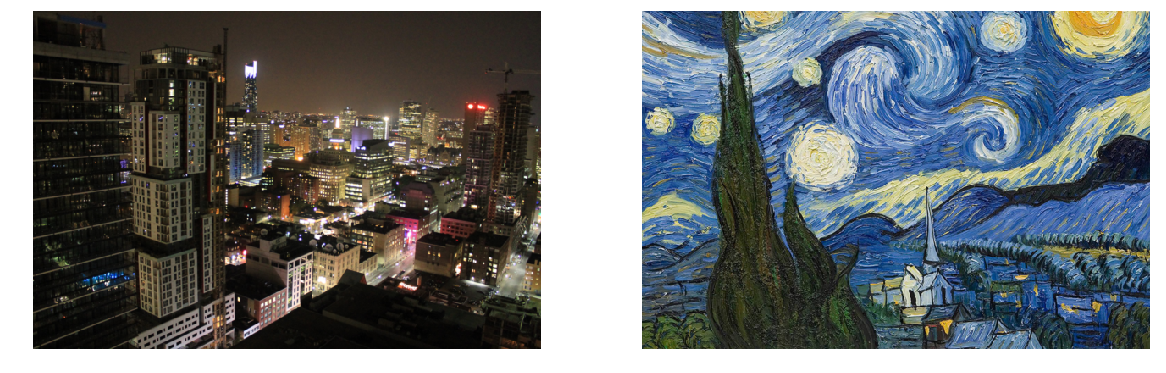

In [36]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

## Feature Extraction

In [37]:
# extraction features from model
def get_features(image,model):
    
    layers = {'0':'conv1_1',  #convi_j:   the number of batch in convolution, the number of layer in that batch
              '5':'conv2_1',
              '10':'conv3_1',
              '19':'conv4_1',
              '21':'conv4_2',  # content extraction , the rest are for style extraction
              '28':'conv5_1'
             }     
    features = {}
    
    for name,layer in model._modules.items():   # iterate all the layers in the model, name is integer indexing the layer
        image = layer(image)   # feed image into the network , its output  is the outputs of that layer
        if name in layers:    # store specific layer's features
            features[layers[name]] = image    # key: conv string  value:output of hidden layer
    
    return features

In [38]:
content_features = get_features(content,vgg)
style_features = get_features(style,vgg)

## Gram Matrix

In [42]:
def gram_matrix(tensor):
    b,d,h,w = tensor.size()   # batch size, depth, height,width
    tensor = tensor.view(d,h * w)
    gram = torch.mm(tensor,tensor.t())
    return gram

In [44]:
style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features} # weigh heavily for earlier layers to recreate style

In [45]:
style_weights = {'conv1_1':1.0,
                 'conv2_1':0.75,
                 'conv3_1':0.2,
                 'conv4_1':0.2,
                 'conv5_1':0.2
                }

In [49]:
# alpha: content image weight   beta: style image weight
content_weight = 1  # alpha
style_weight = 1e6  # beta


In [47]:
target = content.clone().requires_grad_(True).to(device)  # adjust the target

In [48]:
show_every = 300     # show an updated image every 300 iterations
optimizer = optim.Adam([target],lr=0.003)
steps = 2100
height,width,channels = im_convert(target).shape

image_array = np.empty(shape=(300,height,width,channels))  # 300 images to visualize

capture_frame = steps/300                     # capture one image every 7 steps
counter = 0

Iteration:  300
Total loss:  2887836.25


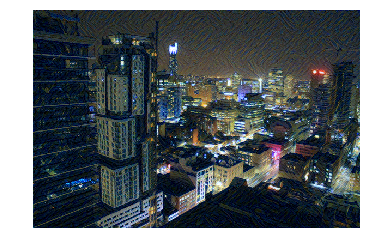

Iteration:  600
Total loss:  949896.0625


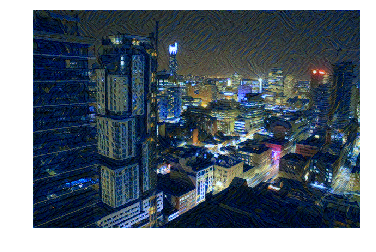

Iteration:  900
Total loss:  658651.125


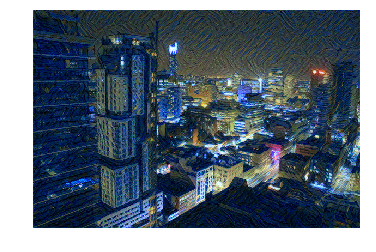

Iteration:  1200
Total loss:  510675.15625


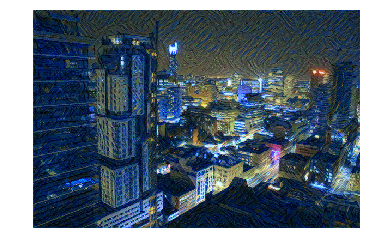

Iteration:  1500
Total loss:  400968.625


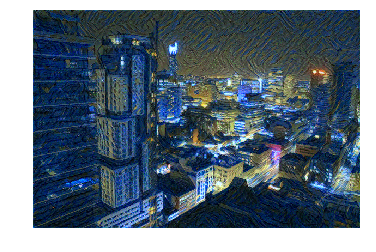

Iteration:  1800
Total loss:  315106.78125


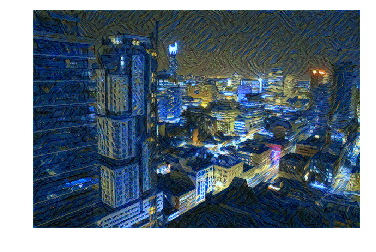

Iteration:  2100
Total loss:  246975.296875


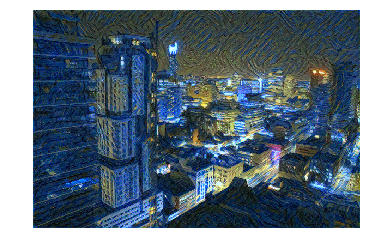

In [50]:
for ii in range(1,steps+1):
    target_features = get_features(target,vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)   # want target to match content
    style_loss = 0
    # iterate the style weights
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)   # want target to match style
        _,d,h,w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
    
    total_loss = content_loss * content_weight + style_loss * style_weight
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % show_every == 0:
        print("Iteration: ", ii)
        print("Total loss: ",total_loss.item())
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()
    
    if ii % capture_frame == 0:  # used as video to see the process
        image_array[counter] = im_convert(target)
        counter += 1
        
        

(-0.5, 599.5, 399.5, -0.5)

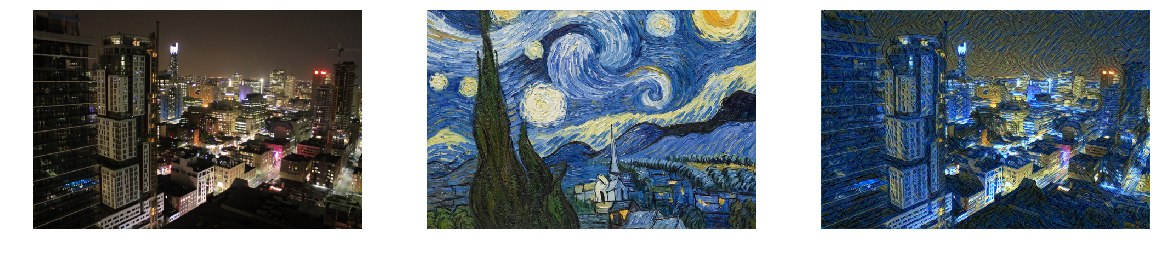

In [51]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')


## Save the transfer process as video

In [56]:
import cv2

In [58]:
frame_height,frame_width,_ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'XVID'),30,(frame_width,frame_height))  # XVID coder  30 frames per second, we have 10 seconds in total

for i in range(0,show_every):
    img = image_array[i]
    img *= 255  # turn into regular RGB
    img = np.array(img,dtype=np.uint8)   
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  # open cv treat img in BGR order
    
    vid.write(img)

vid.release()

In [ ]:
from google.colab import files
files.download('output.mp4')